In [2]:
#### ReduceLROnPlateau####
import os
import pickle
#import rpy2.robjects as robjects
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import scipy.sparse as sp
from torchvision import transforms as tfs
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.loader import HGTLoader
from torch_geometric.loader import LinkNeighborLoader
from torch.cuda.amp import autocast
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
#from torchsummary import summary
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers,node_types,metadata):
        super().__init__()
        self.lin_dict = torch.nn.ModuleDict()
        for node_type in node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels[0])
        # self.lin_dict['miRNA']=Linear(2656, hidden_channels[0])
        # self.lin_dict['gene']=Linear(18454, hidden_channels[0])
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            conv = HGTConv(hidden_channels[i], hidden_channels[i+1], metadata,num_heads)
            self.convs.append(conv)
        # self.lin1 = Linear(hidden_channels[-1], out_channels)
        # self.lin2 = Linear(hidden_channels[-1], out_channels)
        self.relu = nn.GELU()
    def forward(self, x_dict, edge_index_dict):
        for node_type, x in x_dict.items():
            x_dict[node_type] = self.lin_dict[node_type](x).relu_()
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
        # xm=self.relu(self.lin1(x_dict['miRNA']))
        # xg=self.relu(self.lin2(x_dict['gene']))
        xm=x_dict['miRNA']
        xg=x_dict['gene']
        return (xm,xg)

# class MLPBilPredictor(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, num_layers, dropout_rate=0.3):
#         super(MLPBilPredictor, self).__init__()
#         self.lins = torch.nn.ModuleList()
#         self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
#         for _ in range(num_layers - 1):
#             self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
#         self.bilin = torch.nn.Linear(hidden_channels, hidden_channels, bias=False)
#         self.relu = nn.GELU()
#
#     def reset_parameters(self):
#         for lin in self.lins:
#             lin.reset_parameters()
#         self.bilin.reset_parameters()
#
#     def forward(self, x_i, x_j):
#         for lin in self.lins:
#             x_i, x_j = lin(x_i), lin(x_j)
#             x_i, x_j = self.relu(x_i), self.relu(x_j)
#         x = torch.sum(self.bilin(x_i) * x_j, dim=-1)
#         # x2 = torch.sum(self.bilin(x_j) * x_i, dim=-1)
#         # x = x1+x2
#         #x = torch.sum(x_i * x_j, dim=-1)
#         return x

class MLPBilPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout_rate=0.3):
        super(MLPBilPredictor, self).__init__()
        # self.lins = torch.nn.ModuleList()
        # self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        # for _ in range(num_layers - 1):
        #     self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.bilin = torch.nn.Linear(hidden_channels, hidden_channels, bias=False)
        # self.bilin = torch.nn.Linear(in_channels,in_channels, bias=False)
        # self.relu = nn.GELU()

    def reset_parameters(self):
        # for lin in self.lins:
        #     lin.reset_parameters()
        self.bilin.reset_parameters()

    def forward(self, x_i, x_j):
        # for lin in self.lins:
        #     x_i, x_j = lin(x_i), lin(x_j)
        #     x_i, x_j = self.relu(x_i), self.relu(x_j)
        x = torch.sum(self.bilin(x_i) * x_j, dim=-1)
        # x1 = torch.sum(self.bilin(x_i) * x_j, dim=-1)
        # x2 = torch.sum(self.bilin(x_j) * x_i, dim=-1)
        # x = x1+x2
        # x = torch.sum(x_i * x_j, dim=-1)
        return x

class HGTmt(torch.nn.Module):
    def __init__(self,hidden_channels, out_channels, num_heads, num_layers,node_types,metadata):
        super(HGTmt, self).__init__()
        self.hgt=HGT(hidden_channels, out_channels, num_heads, num_layers,node_types,metadata)
        self.predict=MLPBilPredictor(hidden_channels[-1], out_channels, 1, 0.3)

    def encoder(self,x_dict,edge_index_dict):
        xm,xg=self.hgt(x_dict,edge_index_dict)
        #print(xm.size(),xg.size())
        return xm,xg

    def decoder(self,xm,xg,edge):
        xm=xm[edge[0]]
        xg=xg[edge[1]]
        s=self.predict(xm,xg)
        return s

    def forward(self,x_dict,edge_index_dict,label_edge):
        xm,xg=self.encoder(x_dict,edge_index_dict)
        s=self.decoder(xm,xg,label_edge)
        return s

class FocalLoss(nn.Module):
    def __init__(self,alpha=0.25,gamma=2.0,reduce='mean'):
        super(FocalLoss,self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self,classifications,targets):
        # classifcation:[N,K]
        # targets: [N,K]的one-hot编码
        alpha = self.alpha
        gamma = self.gamma
        # classifications = classifications.view(-1)  # 不经过sigmoid的classification；
        # targets = targets.view(-1)                  # 应该是 one-hot
        # ce_loss: 对应公式中 -log(pt),也就是普通的 交叉熵损失；--> 该函数接收未经sigmoid的函数；
        ce_loss = F.binary_cross_entropy_with_logits(classifications, targets, reduction="none")
        #focal loss
        p = torch.sigmoid(classifications)                # 经过sigmoid
        p_t = p * targets + (1 - p) * (1 - targets)       #  计算pt
        loss = ce_loss * ((1 - p_t) ** gamma)             # -log(pt) * (1-pt) ** ganmma
        if alpha >= 0:
            # 对应公式中alpha_t控制损失的权重
            alpha_t = alpha * targets + (1 - alpha) * (1 - targets) # 和pt求解过程一样
            loss = alpha_t * loss                         # 最终focal loss
        if self.reduce=='sum':
            loss = loss.sum()
        elif self.reduce=='mean':
            loss = loss.mean()
        else:
            raise ValueError('reduce type is wrong!')
        return loss

class BCEFocalLoss(torch.nn.Module):

    def __init__(self, gamma=2, alpha=0.25, reduction='elementwise_mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, _input, target):
        pt = torch.sigmoid(_input)
        loss = - self.alpha * (1 - pt) ** self.gamma * target * torch.log(pt) - \
               (1-self.alpha)*pt ** self.gamma * (1 - target) * torch.log(1 - pt)
        #         loss = - self.alpha * pt ** self.gamma * target * torch.log(pt) - \
        #             (1-self.alpha)*(1 - pt)** self.gamma * (1 - target) * torch.log(1 - pt)
        if self.reduction == 'elementwise_mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        return loss

def trainEpoch(model,trainloader,scaler,lossF,device,xm,xg):
    model.train()
    trainloss=0
    auc=0
    aupr=0
    #acc=0
    for step,dat in enumerate(trainloader):
        #print(device)
        #dat=dat.to(device)
        # dat['miRNA'].x=xm
        # dat['gene'].x=xg
        dat=T.ToUndirected()(dat)
        dat=dat.to(device)
        #print(dat)
        out = model(dat.x_dict,dat.edge_index_dict,dat['regulate'].edge_label_index)
        out=out.view(-1)
        #print(out.size())
        rel=dat['regulate'].edge_label
        #print(rel.size())
        #loss = F.binary_cross_entropy_with_logits(out,rel)
        loss=lossF(out,rel)
        #metric=model_evaluation(pre,rel.int())
        #print(out)
        pre=torch.sigmoid(out)
        #print(pre.size())
        #assert torch.isnan(loss).sum() == 0, print(loss)
        metric0=roc_auc_score(rel.cpu().detach().numpy(), pre.cpu().detach().numpy())
        metric1= average_precision_score(rel.cpu().detach().numpy(), pre.cpu().detach().numpy())
        #         scaler.scale(loss).backward()
        #         scaler.step(optimizer)  # optimizer.step
        #         scaler.update()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trainloss = trainloss+loss.item()
        #acc=acc+metric['accuracy']
        auc=auc+metric0
        aupr=aupr+metric1
        # if (step % 100 == 0):
        #     train_loss = (trainloss / (step+1))
        #     auc_batch = (auc / (step+1))
        #     aupr_batch = (aupr / (step+1))
        #     #train_loss.append(trainloss)
        #     print('Batch:',step,train_loss,auc_batch,aupr_batch)
    return (trainloss/(step+1),auc/(step+1),aupr/(step+1))

def evaluate(model,valloader,lossF,device,xm,xg):
    model.eval()
    valloss=0
    valauc=0
    valaupr=0
    with torch.no_grad():
        for step,dat in enumerate(valloader):
            #print(device)
            # dat['miRNA'].x=xm
            # dat['gene'].x=xg
            dat=T.ToUndirected()(dat)
            #print(step)
            dat=dat.to(device)
            out = model(dat.x_dict,dat.edge_index_dict,dat['regulate'].edge_label_index)
            out=out.view(-1)
            #print(out.size())
            rel=dat['regulate'].edge_label
            #print(rel.size())
            #loss = F.binary_cross_entropy_with_logits(out,rel)
            loss=lossF(out,rel)
            #metric=model_evaluation(pre,rel.int())
            #print(rel,pre)
            pre=torch.sigmoid(out)
            #print(pre.size())
            auc=roc_auc_score(rel.cpu(), pre.cpu())
            aupr= average_precision_score(rel.cpu(), pre.cpu())
            valloss = valloss+loss.item()
            valauc=valauc+auc
            valaupr=valaupr+aupr
            # if (step % 100 == 0):
            #     val_loss = (valloss / (step+1))
            #     #val_loss.append(valloss)
            #     val_auc=(valauc/(step+1))
            #     val_aupr=(valaupr/(step+1))
            #     print('Batch:',step,val_loss,val_auc,val_aupr)
    return (valloss/(step+1)),(valauc/(step+1)),(valaupr/(step+1))

# class EarlyStopping():
#     def __init__(self, tolerance=5, min_delta=0.1):

#         self.tolerance = tolerance
#         self.min_delta = min_delta
#         self.counter = 0
#         self.early_stop = False

#     def __call__(self, train_auc, validation_auc):
#         if (train_auc - validation_auc) > self.min_delta:
#             self.counter +=1
#             if self.counter >= self.tolerance:
#                 self.early_stop = True

class EarlyStopping():
    def __init__(self, tolerance=50, min_delta=0.1):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
    def __call__(self, val_best_auc, val_auc):
        if val_auc<val_best_auc:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True


# if __name__ == '__main__':

#     torch.cuda.set_device(0)
#     set_seed(2022)
        
#     with open('dataCombine_negall.pkl','rb') as f:  # Python 3: open(..., 'rb')
#         train_data,val_data,_,m,g = pickle.load(f)

#     train_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
#     val_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
#     #test_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
#     train_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
#     val_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
#     #test_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
#     nodetypes=train_data.node_types
#     metadata=train_data.metadata()

#     train_data['miRNA'].x=train_data['miRNA'].sim
#     train_data['gene'].x=train_data['gene'].sim
#     val_data['miRNA'].x=val_data['miRNA'].sim
#     val_data['gene'].x=val_data['gene'].sim

#     train_data['miRNA'].num_nodes = len(m)
#     train_data['gene'].num_nodes = len(g)
#     val_data['miRNA'].num_nodes = len(m)
#     val_data['gene'].num_nodes = len(g)

#     del train_data['miRNA'].sim
#     del train_data['miRNA'].mm
#     del train_data['miRNA'].seq
#     del train_data['gene'].sim
#     del train_data['gene'].gg
#     del train_data['gene'].seq
#     del train_data['rev_regulate']

#     del val_data['miRNA'].sim
#     del val_data['miRNA'].mm
#     del val_data['miRNA'].seq
#     del val_data['gene'].sim
#     del val_data['gene'].gg
#     del val_data['gene'].seq
#     del val_data['rev_regulate']

#     train_loader = LinkNeighborLoader(
#         data=train_data,
#         num_neighbors={('miRNA','regulate','gene'):[8]*4,('miRNA','cofamily','miRNA'):[8]*4,('gene','coocurrence','gene'):[8]*4},
#         #num_neighbors={('miRNA','regulate','gene'):[-1]*1,('miRNA','cofamily','miRNA'):[-1]*1,('gene','coocurrence','gene'):[-1]*1},
#         #edge_label_index=('miRNA','regulate','gene'),
#         #num_neighbors=[-1]*1,
#         #num_neighbors=[8]*4,
#         edge_label_index=(('miRNA','regulate','gene'),train_data['regulate'].edge_label_index),
#         edge_label=train_data['regulate'].edge_label,
#         batch_size=1024*2,
#         #weight_attr=None,
#         shuffle=True,
#         #num_workers=8, 
#         pin_memory=True,
#     )
#     val_loader = LinkNeighborLoader(
#         data=val_data,
#         num_neighbors={('miRNA','regulate','gene'):[8]*4,('miRNA','cofamily','miRNA'):[8]*4,('gene','coocurrence','gene'):[8]*4},
#         #num_neighbors={('miRNA','regulate','gene'):[-1]*1,('miRNA','cofamily','miRNA'):[-1]*1,('gene','coocurrence','gene'):[-1]*1},
#         #edge_label_index=('miRNA','regulate','gene'),
#         #num_neighbors=[-1]*1,
#         #num_neighbors=[8]*4,
#         edge_label_index=(('miRNA','regulate','gene'),val_data['regulate'].edge_label_index),
#         edge_label=val_data['regulate'].edge_label,
#         batch_size=1024*2,
#         #weight_attr=None,
#         shuffle=True,
#         #num_workers=8, 
#         pin_memory=True,
#     )

#     xm=train_data['miRNA'].x
#     xg=train_data['gene'].x
#     model = HGTmt(hidden_channels=[1024,256,128], out_channels=128, num_heads=8, num_layers=2,node_types=nodetypes,metadata=metadata)
#     #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     #device='cpu'
#     device='cuda:0'
#     #print(device)
#     model.to(device)
#     print(model)
    
#     #torch.cuda.set_device(1)
#     #set_seed(2022)
#     for m in model.modules():
#         if isinstance(m, (torch.nn.Linear)):
#             torch.nn.init.kaiming_normal_(m.weight, mode = 'fan_in')
#     #weight_decay=5e-4
#     optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-3)
#     scaler = torch.cuda.amp.GradScaler(enabled=True)
#     #0.1 0.05 0.01 0.005 0.0001
#     #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100, eta_min=0.000001)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',factor=0.5,verbose=1,min_lr=0.000001,patience=20)
#     lossF=FocalLoss(alpha=0.65, gamma=2,reduce='mean')
#     #lossF=FocalLoss(alpha=-1, gamma=0.2,reduce='mean')
#     #lossF=BCEFocalLoss(gamma=1, alpha=0.75, reduction='elementwise_mean')
#     early_stopping = EarlyStopping(tolerance=20, min_delta=0.15)

#     # Define the early stopping parameters
#     patience = 50
#     #best_va = float('inf')
#     counter = 0
#     #print(device)
#     import time
#     best_val_auc= best_val_aupr= 0
#     best_epoch=-1
#     trainloss=[]
#     valloss=[]
#     valauc=[]
#     trainauc=[]
#     valaupr=[]
#     trainaupr=[]
#     lrchange=[]
#     for epoch in range(1, 1001):
#         since = time.time()
#         print('{} optim: {}'.format(epoch, optimizer.param_groups[0]['lr']))
#         lrchange.append(optimizer.param_groups[0]['lr'])
#         train_loss,train_auc,train_aupr = trainEpoch(model,train_loader,scaler,lossF,device,xm,xg)
#         trainloss.append(train_loss)
#         print('train_loss:',train_loss)
#         val_loss,val_auc,val_aupr = evaluate(model,val_loader,lossF,device,xm,xg)
#         valauc.append(val_auc)
#         valloss.append(val_loss)
#         trainauc.append(train_auc)
#         valaupr.append(val_aupr)
#         trainaupr.append(train_aupr)
#         #time_elapsed = time.time() - since1
#         #print('Val and Testing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#         #scheduler.step() 
#         scheduler.step(val_aupr)
#         if val_aupr > best_val_aupr:
#             best_val_auc = val_auc
#             best_val_aupr=val_aupr
#             counter = 0
#             best_epoch = epoch
#             #print(f'best aupr {epoch}')
#             torch.save(model, './HGT/HGTbest_linkloader_ReduceLR_2.pt')
#             time_elapsed = time.time() - since
#             log = 'Epoch: {:03d}, Epoch complete in {:.0f}m {:.0f}s, trainLoss: {:.4f}, Valloss: {:.4f}, Trainauc: {:.4f}, Valauc: {:.4f}, Valbestauc: {:.4f},Trainaupr: {:.4f}, Valaupr: {:.4f}, Valbestaupr: {:.4f}'
#             print(log.format(epoch, time_elapsed // 60, time_elapsed % 60,train_loss, val_loss,train_auc,val_auc,best_val_auc,train_aupr,val_aupr,best_val_aupr))
#         else:
#             counter += 1
#             time_elapsed = time.time() - since
#             log = 'Epoch: {:03d}, Epoch complete in {:.0f}m {:.0f}s, trainLoss: {:.4f}, Valloss: {:.4f}, Trainauc: {:.4f}, Valauc: {:.4f}, Valbestauc: {:.4f},Trainaupr: {:.4f}, Valaupr: {:.4f}, Valbestaupr: {:.4f}'
#             print(log.format(epoch, time_elapsed // 60, time_elapsed % 60,train_loss, val_loss,train_auc,val_auc,best_val_auc,train_aupr,val_aupr,best_val_aupr))
#             if counter >= patience:
#                 print(f'Early stopping at epoch {epoch}')
#                 print(f'best aupr at epoch {best_epoch}')
#                 break
                
#         # scheduler.step() 
#         # #scheduler.step(val_aupr)
#         # time_elapsed = time.time() - since
#         # log = 'Epoch: {:03d}, Epoch complete in {:.0f}m {:.0f}s, trainLoss: {:.4f}, Valloss: {:.4f}, Trainauc: {:.4f}, Valauc: {:.4f}, Valbestauc: {:.4f},Trainaupr: {:.4f}, Valaupr: {:.4f}, Valbestaupr: {:.4f}'
#         # print(log.format(epoch+1, time_elapsed // 60, time_elapsed % 60,train_loss, val_loss,train_auc,val_auc,best_val_auc,train_aupr,val_aupr,best_val_aupr))

#     with open('./HGT/HGTResult_linkloader_ReduceLR_2.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#         pickle.dump([trainloss, trainauc,trainaupr,valloss,valauc,valaupr,lrchange], f)

#     torch.save(model, './HGT/HGT_linkloader_ReduceLR_2.pt')

In [3]:
torch.cuda.set_device(0)
set_seed(2022)

In [4]:
########### CPU #####

import matplotlib.pyplot as plt
#HGT = torch.load("./HGT/HGTbest_linkloader_ReduceLR_2_2.pt")
#HGT = torch.load("./results/hnuResults/HGT/HGTbest_linkloader_ReduceLR_2.pt") ##hnu/24g
HGT = torch.load("./HGT/HGTbest_cpu_ReduceLR_usingmiRNAanchor.pt") ##hnu/24g
#HGT = HGT.to("cuda:0")
HGT = HGT.to("cpu")
print(HGT)

with open('dataCombine_negall_usingmiRNAanchor.pkl','rb') as f:  # Python 3: open(..., 'rb')
    train_data,_,test_data,m,g = pickle.load(f)

train_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
#val_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
test_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
train_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
#val_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
test_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
nodetypes=train_data.node_types
metadata=train_data.metadata()

from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

HGT.eval()
valloss=0
valauc=0
with torch.no_grad():
    out = HGT(test_data.sim_dict,test_data.edge_index_dict,test_data['regulate'].edge_label_index)
#     out = HGT(test_data.seq_dict, test_data.sim_dict,test_data.edge_index_dict,test_data['regulate'].edge_label_index)
    out=out.view(-1)
    rel=test_data['regulate'].edge_label
    #loss = F.binary_cross_entropy_with_logits(out,rel)
    pre=torch.sigmoid(out) 

    auc=roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
    aupr= average_precision_score(rel.detach().numpy(), pre.detach().numpy())

print(aupr,auc)
###0.7677882817816156 0.85425414952724

HGTmt(
  (hgt): HGT(
    (lin_dict): ModuleDict(
      (miRNA): Linear(2656, 1024, bias=True)
      (gene): Linear(18454, 1024, bias=True)
    )
    (convs): ModuleList(
      (0): HGTConv(-1, 256, heads=8)
      (1): HGTConv(-1, 128, heads=8)
    )
    (relu): GELU(approximate='none')
  )
  (predict): MLPBilPredictor(
    (bilin): Linear(in_features=128, out_features=128, bias=False)
  )
)
0.6573901576197811 0.7953477644067963


In [ ]:
# ####### GPU############
# import matplotlib.pyplot as plt
# #HGT = torch.load("./HGT/HGTbest_linkloader_ReduceLR_2_2.pt") ##4gpu/40g
# #HGT = torch.load("./HGT/HGTbest_linkloader_ReduceLR_2_1.pt") ##10gpu/10g
# #HGT = torch.load("./HGT/HGTbest_linkloader_ReduceLR_2.pt") ##10gpu/10g
# HGT = torch.load("./results/hnuResults/HGT/HGTbest_linkloader_ReduceLR_2.pt") ##hnu/24g
# device='cuda:0'
# HGT = HGT.to(device)
# #HGT = HGT.to("cpu")
# print(HGT)

# with open('dataCombine_negall.pkl','rb') as f:  # Python 3: open(..., 'rb')
#     train_data,_,test_data,m,g = pickle.load(f)

# #train_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
# #val_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
# test_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
# #train_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
# #val_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
# test_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
# nodetypes=test_data.node_types
# metadata=test_data.metadata()
# del train_data
# # train_data['miRNA'].x=train_data['miRNA'].sim
# # train_data['gene'].x=train_data['gene'].sim
# # val_data['miRNA'].x=val_data['miRNA'].sim
# # val_data['gene'].x=val_data['gene'].sim
# test_data['miRNA'].x=test_data['miRNA'].sim
# test_data['gene'].x=test_data['gene'].sim

# # train_data['miRNA'].num_nodes = len(m)
# # train_data['gene'].num_nodes = len(g)
# # val_data['miRNA'].num_nodes = len(m)
# # val_data['gene'].num_nodes = len(g)
# test_data['miRNA'].num_nodes = len(m)
# test_data['gene'].num_nodes = len(g)

# # del train_data['miRNA'].sim
# # del train_data['miRNA'].mm
# # del train_data['miRNA'].seq
# # del train_data['gene'].sim
# # del train_data['gene'].gg
# # del train_data['gene'].seq
# # del train_data['rev_regulate']

# # del val_data['miRNA'].sim
# # del val_data['miRNA'].mm
# # del val_data['miRNA'].seq
# # del val_data['gene'].sim
# # del val_data['gene'].gg
# # del val_data['gene'].seq
# # del val_data['rev_regulate']
# del test_data['miRNA'].sim
# del test_data['miRNA'].mm
# del test_data['miRNA'].seq
# del test_data['gene'].sim
# del test_data['gene'].gg
# del test_data['gene'].seq
# del test_data['rev_regulate']

# test_loader = LinkNeighborLoader(
#     data=test_data,
#     num_neighbors={('miRNA','regulate','gene'):[8]*4,('miRNA','cofamily','miRNA'):[8]*4,('gene','coocurrence','gene'):[8]*4},
#     #num_neighbors={('miRNA','regulate','gene'):[-1]*1,('miRNA','cofamily','miRNA'):[-1]*1,('gene','coocurrence','gene'):[-1]*1},
#     #edge_label_index=('miRNA','regulate','gene'),
#     #num_neighbors=[-1]*1,
#     #num_neighbors=[8]*4,
#     edge_label_index=(('miRNA','regulate','gene'),test_data['regulate'].edge_label_index),
#     edge_label=test_data['regulate'].edge_label,
#     batch_size=1024*2,
#     #weight_attr=None,
#     shuffle=True,
#     #num_workers=8, 
#     pin_memory=True,
# )

# del test_data

# from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# #lossF=FocalLoss(alpha=0.65, gamma=2,reduce='mean')

# HGT.eval()
# valloss=0
# valauc=0
# valaupr=0
# allpre=[]
# allrel=[]
# allmid=[]
# allgid=[]
# with torch.no_grad():
#     for step,dat in enumerate(test_loader):
#         dat=T.ToUndirected()(dat)
#         #print(step)
#         dat=dat.to(device)
#         out = HGT(dat.x_dict,dat.edge_index_dict,dat['regulate'].edge_label_index)
#         out=out.view(-1)
#         #print(out.size())
#         rel=dat['regulate'].edge_label
#         #loss = F.binary_cross_entropy_with_logits(out,rel)
#         #loss=lossF(out,rel)
#         #metric=model_evaluation(pre,rel.int())
#         #print(rel,pre)
#         pre=torch.sigmoid(out)
#         mid=dat['regulate'].edge_label_index[0]
#         gid=dat['regulate'].edge_label_index[1]
#         allpre.append(pre)
#         allrel.append(rel)
#         allmid.append(mid)
#         allgid.append(gid)
#         auc=roc_auc_score(rel.cpu(), pre.cpu())
#         aupr= average_precision_score(rel.cpu(), pre.cpu())
        
#         #valloss = valloss+loss.item()
#         valauc=valauc+auc
#         valaupr=valaupr+aupr
#         if (step % 100 == 0):
#             #val_loss = (valloss / (step+1))
#             #val_loss.append(valloss)
#             val_auc=(valauc/(step+1))
#             val_aupr=(valaupr/(step+1))
#             print('Batch:',step,val_auc,val_aupr)

In [ ]:
# print(valaupr/(step+1),valauc/(step+1)) ## 0.8204970946857437 0.8881875252901438 4gpu/40g

In [ ]:
## 0.8204970946857437 0.8881875252901438 4gpu/40g 0.8205453827072802 0.88822022442273 #0.8205156748083514 0.8882234753712277
## 0.8433474598160717 0.9008241634381097 hnu/24g 0.8454114808129801 0.9023515918845327
## 8269891851420326 0.8916291395798912 10gpu/10
## 0.8854302249312292 0.9301592374808392 10gpu/10
# 0.8878870095243053 0.9316347515585272 # 0.8854939537290857 0.9301708208640932 #0.8855597445596703 0.930230828633112

In [5]:
# pre=allpre[0]
# rel=allrel[0]
# mid=allmid[0]
# gid=allgid[0]
# for i in range(1,len(allpre)):
#     pre=torch.cat([pre,allpre[i]])
#     rel=torch.cat([rel,allrel[i]])
#     mid=torch.cat([mid,allmid[i]])
#     gid=torch.cat([gid,allgid[i]])

# pre=pre.cpu()
# rel=rel.cpu()
# mid=mid.cpu()
# gid=gid.cpu()

allrelpos=torch.nonzero(rel==1).squeeze()
print(allrelpos.size())
allrelneg=torch.nonzero(rel==0).squeeze()
print(allrelneg.size())

allprepos=torch.nonzero(pre>=0.5).squeeze()##从0开始
print(allprepos.size())
allpreneg=torch.nonzero(pre<0.5).squeeze()##从0开始
print(allpreneg.size())

a=set(allprepos.numpy())
b=set(allrelpos.numpy())
c=torch.tensor(list(a&b))
tp=c
print(tp.size())#1569

a=set(allprepos.numpy())
b=set(allrelneg.numpy())
c=torch.tensor(list(a&b))
fp=c
print(fp.size())#793

a=set(allpreneg.numpy())
b=set(allrelneg.numpy())
c=torch.tensor(list(a&b))
tn=c
print(tn.size())#5197

a=set(allpreneg.numpy())
b=set(allrelpos.numpy())
c=torch.tensor(list(a&b))
fn=c
print(fn.size())#654

recall=tp.size(0)/(tp.size(0)+fn.size(0))
print(recall)

precision=tp.size(0)/(tp.size(0)+fp.size(0))
print(precision)

f1 = 2 * precision * recall / (precision + recall)
print(f1)

# with open('./results/HGTlinkloader_resultgpu.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([tp,fp,tn,fn,rel,pre], f)
# with open('./results/hnuResults/results/HGTlinkloader_resultgpu.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([tp,fp,tn,fn,rel,pre], f)

with open('./results/usingmiRNA/HGTfull_resultcpu_usingmiRNAanchor.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([tp,fp,tn,fn,rel,pre], f)

torch.Size([33360])
torch.Size([80036])
torch.Size([69445])
torch.Size([43951])
torch.Size([29262])
torch.Size([40183])
torch.Size([39853])
torch.Size([4098])
0.8771582733812949
0.42136942904456764
0.5692719225718593


In [6]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def get_confusion_matrix(trues, preds):
    labels = [0,1]
    conf_matrix = confusion_matrix(trues, preds)
    return conf_matrix

def get_acc_p_r_f1(trues, preds):
    labels = [1]
    TP,FP,FN,TN = 0,0,0,0
    for label in labels:
        preds_tmp = np.array([1 if pred == label else 0 for pred in preds])
        trues_tmp = np.array([1 if true == label else 0 for true in trues])
        # print(preds_tmp, trues_tmp)
        # print()
        # TP预测为1真实为1
        # TN预测为0真实为0
        # FN预测为0真实为1
        # FP预测为1真实为0
        TP += ((preds_tmp == 1) & (trues_tmp == 1)).sum()
        TN += ((preds_tmp == 0) & (trues_tmp == 0)).sum()
        FN += ((preds_tmp == 0) & (trues_tmp == 1)).sum()
        FP += ((preds_tmp == 1) & (trues_tmp == 0)).sum()
    print(TP, FP, FN,TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

def get_p_r_f1_from_conf_matrix(conf_matrix):
    TP,FP,FN,TN = 0,0,0,0
    labels = [1]
    nums = len(labels)
    for i in labels:
        TP += conf_matrix[i, i]
        FP += (conf_matrix[:i, i].sum() + conf_matrix[i+1:, i].sum())
        FN += (conf_matrix[i, i+1:].sum() + conf_matrix[i, :i].sum())
    print(TP, FP, FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

t=rel
s=pre
t1=t.cpu().numpy()
print(len(t1))
print(len(t1[t1==1]))
s1=s.cpu().numpy()
s1[s1>0.5]=1
s1[s1<=0.5]=0
print(len(s1[s1==1]),len(s1[s1==0]))
mat=get_confusion_matrix(t1, s1)
precision, recall, f1=get_p_r_f1_from_conf_matrix(mat)
print(precision, recall, f1)
precision, recall, f1=get_acc_p_r_f1(t.cpu().numpy(), s1)
print(precision, recall, f1)

113396
33360
69445 43951
29262 40183 4098
0.42136942904456764 0.8771582733812949 0.5692719225718593
29262 40183 4098 39853
0.42136942904456764 0.8771582733812949 0.5692719225718593


In [7]:
import os
import pickle
import torch
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
# with open('./results/HGTlinkloader_resultgpu.pkl','rb') as f:  # Python 3: open(..., 'rb')
#         _,_,_,_,t,s = pickle.load(f)
# with open('./results/hnuResults/results/HGTlinkloader_resultgpu.pkl','rb') as f:  # Python 3: open(..., 'rb')
#         _,_,_,_,t,s = pickle.load(f)

with open('./results/HGTfull_resultcpu_usingmiRNAanchor.pkl','rb') as f:  # Python 3: open(..., 'rb')
        _,_,_,_,t,s = pickle.load(f)
fpr, tpr, thresholds = roc_curve(t.cpu().numpy(), s.cpu().numpy(), pos_label=1)
testauc=auc(fpr,tpr)#0.8198
print(testauc)
precision, recall, th = precision_recall_curve(t.cpu().numpy(), s.cpu().numpy(),pos_label=1)
testaupr= average_precision_score(t.cpu().numpy(),s.cpu().numpy(),pos_label=1)
print(testaupr) #0.8026

0.7953477644067963
0.6573901576197811


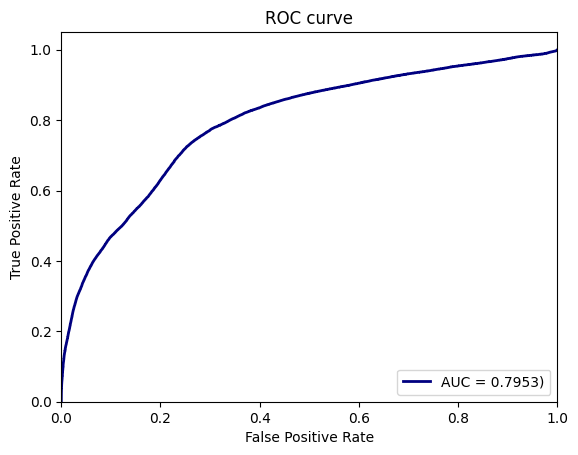

In [8]:
plt.figure()
plt.step(fpr, tpr,color='navy',linewidth=2,label='AUC = {0:.4f})'.format(testauc))
#plt.plot([0, 0], [1, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc=4)
plt.savefig("auc_curve.jpg")

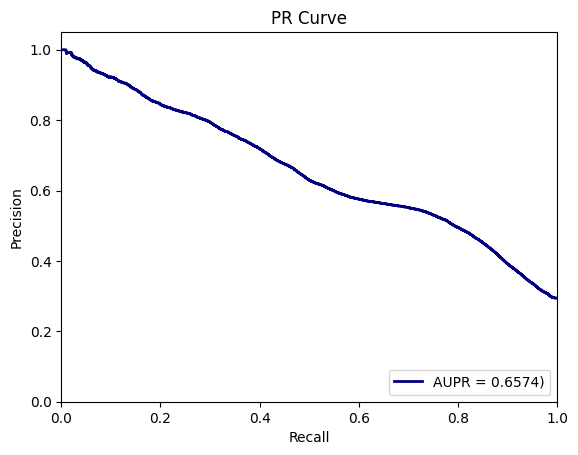

In [9]:
plt.figure()
plt.step(recall,precision,color='navy',linewidth=2,label='AUPR = {0:.4f})'.format(testaupr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR Curve')
plt.legend(loc=4)
plt.savefig("pr_curve.jpg")

In [ ]:
# with open('./HGT/HGTResult_linkloader_ReduceLR_2_2.pkl','rb') as f:  # Python 3: open(..., 'rb') ## gpu/40
#         trainloss, trainauc,trainaupr,valloss,valauc,valaupr,lrchange = pickle.load(f)

In [24]:
with open('./results/hnuResults/HGT/HGTResult_linkloader_ReduceLR_2.pkl','rb') as f:  # Python 3: open(..., 'rb')
        trainloss, trainauc,trainaupr,valloss,valauc,valaupr,lrchange = pickle.load(f)

In [10]:
with open('./HGT/HGTResult_cpu_ReduceLR_usingmiRNAanchor.pkl','rb') as f:  # Python 3: open(..., 'rb')
        trainloss, trainauc,trainaupr,valloss,valauc,valaupr,lrchange = pickle.load(f)

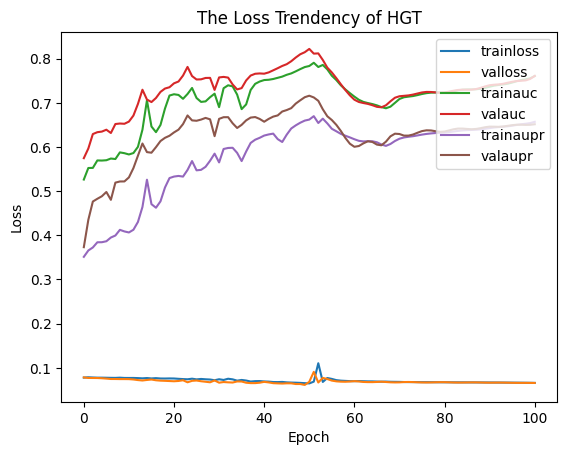

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(trainloss,label='trainloss')
plt.plot(valloss,label='valloss')
plt.plot(trainauc,label='trainauc')
plt.plot(valauc,label='valauc')
plt.plot(trainaupr,label='trainaupr')
plt.plot(valaupr,label='valaupr')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('The Loss Trendency of HGT')
plt.legend(loc=1)

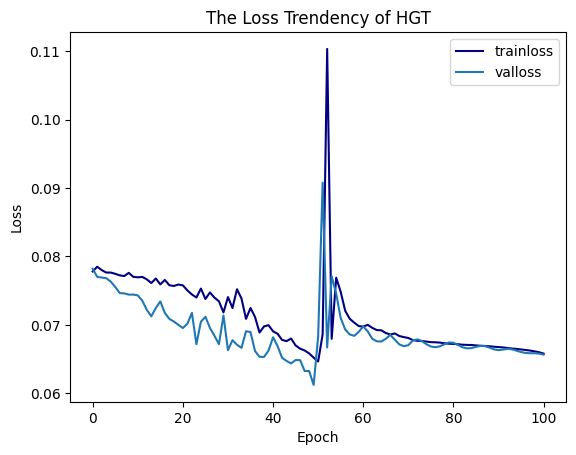

In [12]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainloss,label='trainloss',color='navy')
plt.plot(valloss,label='valloss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.xlim([0.0, 300])
plt.title('The Loss Trendency of HGT')
plt.legend(loc=1)

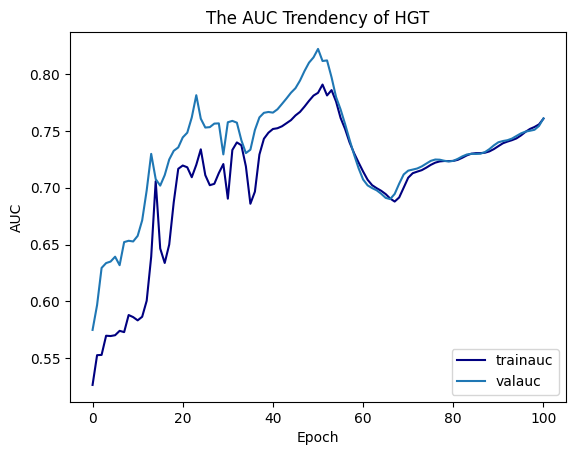

In [13]:
plt.figure()
plt.plot(trainauc,label='trainauc',color='navy')
plt.plot(valauc,label='valauc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
#plt.ylim([0.7, 0.9])
#plt.xlim([0.0, 1.0])
plt.title('The AUC Trendency of HGT')
plt.legend(loc=4)

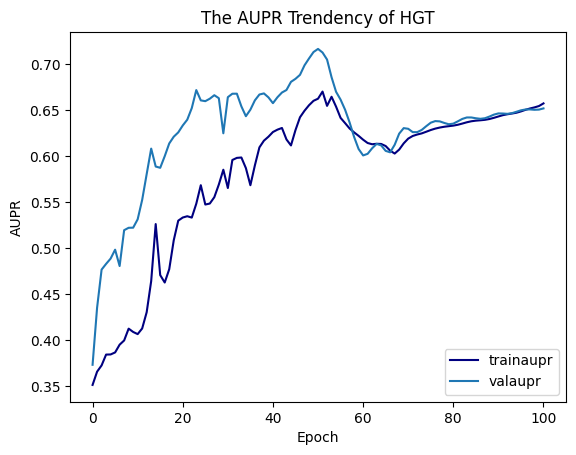

In [14]:
plt.figure()
plt.plot(trainaupr,label='trainaupr',color='navy')
plt.plot(valaupr,label='valaupr')
plt.xlabel('Epoch')
plt.ylabel('AUPR')
plt.title('The AUPR Trendency of HGT')
plt.legend(loc=4)